#  Keeletehnoloogia

In [85]:
# Colabi jaoks
!pip install estnltk==1.7.2

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
# Vajadusel kasutada üleslaetud failide lahtipakkimiseks
# Failide lahtipakkimine
#!unzip test.zip
#!unzip train.zip

### Faili- ja kaustateede määramine


In [87]:
# Faili-ja kaustateede määramine
folderTrain = "train/"
folderTest = "test/"
fileTestSample = "ilu_0021_margenduseta.kym"

### Vajalike moodulite importimine

In [88]:
# Vajalike moodulite importimine toimub selles plokis
import html
from html import unescape
import re
import csv
from nltk.tbl.template import Template
from nltk.tag.brill import Pos, Word
from nltk.tag import BrillTaggerTrainer
import nltk
from estnltk import Text
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Kood 

In [89]:
# Korpuse õigele kujule viimine
def preprocess_corpus(folder):
  corpus_all = []
  pattern_word = r'(.+?)\s+\S+\s+//_(\S+)_'
  for filename in os.listdir(folder):
    with open(os.path.join(folder, filename), 'r', encoding='utf-8') as file:
              corpus = file.read()
              # otsime üles laused
              sentences = re.findall(r'<s>(.*?)</s>', corpus, re.DOTALL)
              for sentence in sentences:
                  # Teisendame täpitähtedeks
                  sentence = unescape(sentence)
                  # Eraldame sõna ja sõnaliigi
                  pairs = re.findall(pattern_word, sentence)
                  # väiketähestame sõnad
                  pair = [(word.lower(), tag) for word, tag in pairs]

                  corpus_all.append(pair)

  corpus_all = [sentence for sentence in corpus_all if any(pair for pair in sentence)]
  return corpus_all

In [90]:
train_corpus = preprocess_corpus(folderTrain)
test_corpus = preprocess_corpus(folderTest)

In [100]:
default_tagger = nltk.DefaultTagger("S")

unigram_tagger = nltk.UnigramTagger(train_corpus, backoff = default_tagger)

bigram_tagger = nltk.BigramTagger(train_corpus, backoff = unigram_tagger )

trigram_tagger = nltk.TrigramTagger(train_corpus, backoff = bigram_tagger)

hmm_tagger = nltk.HiddenMarkovModelTagger.train(train_corpus)

In [101]:
# Brilli tagger
Template._cleartemplates()
templates = [Template(Pos([-1]), Word([0]))]

trainer = nltk.tag.brill_trainer.BrillTaggerTrainer(unigram_tagger, templates, trace=3)
brill_tagger = trainer.train(train_corpus, max_rules=500)

TBL train (fast) (seqs: 35100; tokens: 523414; tpls: 1; min score: 2; min acc: None)
Finding initial useful rules...
    Found 3223 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
 227 236   9   0  | D->J if Pos:Z@[-1] & Word:vaid@[0]
 112 342 230   0  | D->J if Pos:Z@[-1] & Word:siis@[0]
  78 122  44   0  | S->K if Pos:S@[-1] & Word:ajal@[0]
  77  90  13   0  | D->J if Pos:S@[-1] & Word:ehk@[0]
  54  56   2   0  | A->V if Pos:V@[-1] & Word:tehtud@[0]
  54 113  59   1  | D->K if Pos:S@[-1] & Word:alla@[0]
  52  69  17   0  | K->D if Pos:V@[-1] & Word:vastu@[0]
  50  61  11   2  | S->V if Pos:V@[-1] & Word:pea@[0]
  45  45   0   0  | K-

In [102]:
# ESTNLtk tagger
gold_standard_tags = []
estnltk_tags = []

for sentence in test_corpus:
    #lisame õige tägi järjendisse
    words, gold_tags = zip(*sentence)
    gold_standard_tags.extend(list(gold_tags))
    # taggime estnltk ja lisame tagi järjendisse
    tagged_sentence = Text(" ".join(words)).tag_layer()
    estnltk_tags.extend([tag[0] for tag in tagged_sentence.partofspeech])

# Arvutame täpsuse
correct_tags = 0
total_tags = len(gold_standard_tags)
#vaatame iga paari puhul kas on sama
for gold_tag, estnltk_tag in zip(gold_standard_tags, estnltk_tags):
    if gold_tag == estnltk_tag:
        correct_tags += 1

accuracy = correct_tags / total_tags

In [ ]:
# Märgendage failis ilu_0021_margenduseta.kym, kus puuduvad märgendid
with open(fileTestSample, 'r', encoding='utf-8') as file:
    untagged_corpus = file.read()

untagged_corpus = html.unescape(untagged_corpus)


# EstNLTK tagger
flattened_c = ' '.join([' '.join([word[0] for word in sentence]) for sentence in untagged_corpus])
corp = Text(flattened_c)
corp.tag_layer()
estnltk_tags_1 = [tag[0] for tag in corp.partofspeech]

# Töötleme teksti

custom_tokenizer = nltk.RegexpTokenizer(r'<[^>]+>|[\w-]+|[\.,;!?]')

words = custom_tokenizer.tokenize(untagged_corpus)


# Faili kirjutmamine
with open('ingerma_katariina.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')

    unigram_tags = unigram_tagger.tag(words)
    bigram_tags = bigram_tagger.tag(words)
    trigram_tags = trigram_tagger.tag(words)
    hmm_tags = hmm_tagger.tag(words)
    brill_tags = brill_tagger.tag(words)


    for i in range(len(words)):
        if words[i] in ('<p>', '</p>', '<s>', '</s>'):
            writer.writerow([words[i]])
        else:
            writer.writerow([html.unescape(words[i]), unigram_tags[i][1], bigram_tags[i][1], trigram_tags[i][1], hmm_tags[i][1], brill_tags[i][1]])


## Tulemuste väljatrükk, diagramm ja analüüs

In [104]:
print(round(unigram_tagger.accuracy(test_corpus), 4), "UnigramTagger")

print(round(bigram_tagger.accuracy(test_corpus), 4), "BigramTagger")

print(round(trigram_tagger.accuracy(test_corpus), 4), "TrigramTagger")

print(round(hmm_tagger.accuracy(test_corpus), 4), "HiddenMarkovModelTagger")

print(round(brill_tagger.accuracy(test_corpus), 4), "BrillTagger")

print(f"{accuracy/100:.4%} EestNTLK")

0.9331 UnigramTagger
0.9373 BigramTagger
0.9364 TrigramTagger
0.8476 HiddenMarkovModelTagger
0.9369 BrillTagger
0.2020% EestNTLK


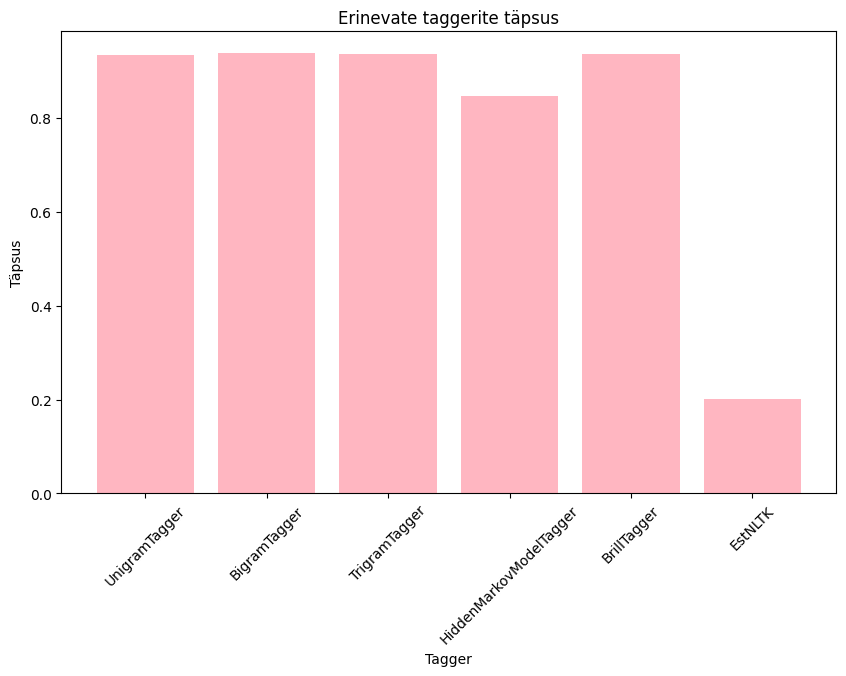

In [105]:
import matplotlib.pyplot as plt

taggers = ["UnigramTagger", "BigramTagger", "TrigramTagger", "HiddenMarkovModelTagger", "BrillTagger", "EstNLTK"]
accuracy_scores = [unigram_tagger.accuracy(test_corpus), bigram_tagger.accuracy(test_corpus),
                   trigram_tagger.accuracy(test_corpus), hmm_tagger.accuracy(test_corpus),
                   brill_tagger.accuracy(test_corpus), accuracy]


plt.figure(figsize=(10, 6))
plt.bar(taggers, accuracy_scores, color='lightpink')
plt.xlabel('Tagger')
plt.ylabel('Täpsus')
plt.title('Erinevate taggerite täpsus')
plt.xticks(rotation=45)

plt.show()


Analüüs:<br>
Esimesest viiest taggerist on kõige madalama tulemusega unigram tagger. See on ilmselt sellepärast, et unigram on neist kõige lihtsam. Ta ei võta arvesse konteksti ja ümbritsevaid sõnu. Eesti keeles on see väga oluline. Seega on loogiline, et selle täpsus on veidi madalam. Lisaks tema backoff on defaulttagger nimisõna, mis ilmselt ei ole ka kõige täpsem. <br>
Bigram ja trigrami tulemus on peaaegu võrdne. Natukene kõrgemad kui unigrami omad, sest ta võtab arvesse natuke konteksti kuna kasutab bi/trigramme. Aga kontekst pole ilmslelt siiski piisavalt põhjalik, et kõike õigesti taggida.
<br>
HHMI Tagger oli väiksema täpsusega. See võib tähendada, et HMM Tagger ei olnud selle konkreetse tekstikorpuse jaoks kõige sobivam tagger. Muidu eeldaksin, et HMM on parema tulemusega kui uni- bi ja trigram, kuna see mudel on keerukam.
 <br>
BrillTagger on transformatsioonipõhine tagger, mille täpsus sõltub reeglitest. Proovisin erineva reeglitearvuga, ja tulemused suuremate arvudega läksid natukene paremaks. <br>
Eeldaks, et ESTNLTK tagger on neist kõige parem aga miskipärast mu andmetega oli see väga kehv. Uurisin ja leidsin, et estnltk leiab rohkem tage. Ei oska öelda, milles asi on ja seega on see list sassi läinud ja andmed kuidagi nihkunud ja estntlk taggeri tulemus pole korrektne. Muidu arvan, et see oleks nendest kõikidest kindlasti kõige parem.